# Approche neuronale 

## Paramètres

In [9]:
import cv2 as cv

face_cascade = cv.CascadeClassifier('../Phase 1/haarcascade_frontalface_default.xml')
eye_cascade = cv.CascadeClassifier('../Phase 1/haarcascade_eye.xml')

img = cv.imread('../Image/img_label_2.jpg')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Dimension de l'image capturée pour avoir des données uniforme.
desired_width = 24
desired_height = 24

scale_factor = 1.3 # Un facteur plus petit augmente la chance de détecter des visages plus petits, mais peut aussi augmenter les faux positifs.
min_neighbors = 5 # Augmenter cette valeur réduit les faux positifs. Cela définit le nombre de voisins qu'un rectangle doit avoir pour être retenu.

nb_label = 2;

## Détection des yeux d'un viage, et création d'un vecteur à partir des yeux détecté.

In [2]:
import cv2 as cv
import numpy as np
    
def vectoriser_oeil(photo_personnalite, face_cascade = face_cascade, eye_cascade = eye_cascade, desired_width = 24, desired_height = 24, scale_factor=1.3, min_neighbors=5, show_results=False):
    gray = cv.cvtColor(photo_personnalite, cv.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scale_factor, min_neighbors)

    vecteurs_oeils = []

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) == 0:
            # Aucun œil détecté
            return None 
        for (ex, ey, ew, eh) in eyes:
            eye_roi = roi_gray[ey: ey + eh, ex: ex + ew]
            resized_eye = cv.resize(eye_roi, (desired_width, desired_height))
            eye_vector_normalized = resized_eye.flatten() / 255.0
            vecteurs_oeils.append(eye_vector_normalized)

            if show_results:
                plt.imshow(photo_personnalite)
                #plt.imshow(cv.cvtColor(photo_personnalite, cv.COLOR_BGR2RGB))
                plt.title("Image d'entré")
                plt.show()
                
                plt.imshow(cv.resize(eye_roi, (desired_width, desired_height)), cmap='gray')
                plt.title("Œil Détecté")
                plt.show()
                
                plt.plot(eye_vector_normalized)
                plt.title("Vecteur de l'Œil Normalisé")
                plt.show()

    return vecteurs_oeils
        
# vectoriser_oeil(img, show_results=False, scale_factor=1.2)
# Maintenant, eye_vector_normalized peut être utilisé pour l'apprentissage
# eye_vector_normalized

In [3]:
# Étape 1 : Lire le Fichier JSON

import json

# Charger le fichier JSON
with open('../Data/sorted_by_label.json', 'r') as file:
    data = json.load(file)

# Utiliser seulement les 30 premiers labels
selected_labels = list(data['data'].keys())[:nb_label]

# Étape 2 : Calculer les Vecteurs pour Chaque Image

vectors_by_class = {label: [] for label in selected_labels}

for label in selected_labels:
    for image_name in data['data'][label]:
        img_path = f'../Image/img_align_celeba/img_align_celeba/{image_name}'
        img = cv.imread(img_path)
        # Assurez-vous que l'image a été chargée correctement
        if img is not None:
            vecteurs = vectoriser_oeil(img, show_results=False)
            if vecteurs is not None:
                vectors_by_class[label].extend(vecteurs)
            else:
                print(f"Aucun œil détecté pour l'image {image_name}")

# Étape 3 : Calculer le Vecteur Moyen pour Chaque Label

mean_vectors = {}
for label, vectors in vectors_by_class.items():
    # Vérifier que tous les vecteurs ont la même longueur
    if all(len(vec) == len(vectors[0]) for vec in vectors):
        mean_vectors[label] = np.mean(vectors, axis=0).tolist()
        print(f"Success : Les vecteurs pour le label {label} ont la même longueur.")
    else:
        print(f"Erreur : Les vecteurs pour le label {label} n'ont pas la même longueur.")

# Étape 4 : Enregistrer en Format JSON

with open('../Data/mean_vectors.json', 'w') as json_file:
    json.dump(mean_vectors, json_file, indent=4) # Indent = Nombre d'espaces à chaque colonne du fichier JSON (améliore la lecture du fichier)
    
# Ici, on obtient le vecteur moyen des yeux observé pour chaque label de personnes.

Aucun œil détecté pour l'image 090781.jpg
Aucun œil détecté pour l'image 142874.jpg
Aucun œil détecté pour l'image 157602.jpg
Success : Les vecteurs pour le label 1 ont la même longueur.
Success : Les vecteurs pour le label 2 ont la même longueur.


In [4]:
# Étape 5 : Classification 

def classifier(nouveau_vecteur, vecteurs_moyens):
    classe_plus_proche = None
    distance_minimale = float('inf')

    for label, vecteur_moyen in vecteurs_moyens.items():
        distance = np.linalg.norm(np.array(nouveau_vecteur) - np.array(vecteur_moyen))
        if distance < distance_minimale:
            distance_minimale = distance
            classe_plus_proche = label

    return classe_plus_proche


In [5]:
# Affichier une image aléatoire du label prédit.

import matplotlib.pyplot as plt
import cv2 as cv
import random
import json
from PIL import Image

# Chemin vers votre fichier JSON contenant les images par label
fichier_images_json = '../Data/sorted_by_label.json'

# Charger les noms des images à partir du fichier JSON
with open(fichier_images_json, 'r') as file:
    images_par_label = json.load(file)['data']
    

def pick_random_img_in_label(classe_predite): 
    if classe_predite in images_par_label:
        # Vous pouvez choisir une image au hasard dans la liste pour ce label
        nom_image = random.choice(images_par_label[classe_predite])
        print(f"On charge l'image {nom_image}")
        # Ou simplement prendre la première image
        # nom_image = images_par_label[classe_predite][0]
    
        chemin_image = f'../Image/img_align_celeba/img_align_celeba/{nom_image}'  # Modifier selon l'organisation de vos données
    
        # Charger et afficher l'image
        img_label = cv.imread(chemin_image)
        if img_label is not None:
            #plt.imshow(cv.cvtColor(img_label, cv.COLOR_BGR2RGB))
            plt.imshow(img_label)
            plt.title(f"Image du label {classe_predite}")
            plt.show()
            
            # # Charger l'image en utilisant PIL
            # image = Image.open("../Image/people1.png")
            # # Afficher l'image
            # plt.imshow(image)
            # plt.show()
        else:
            print(f"Impossible de charger l'image {nom_image}.")


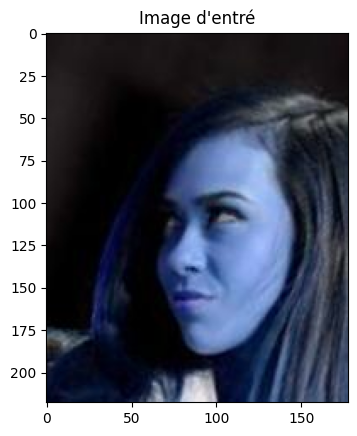

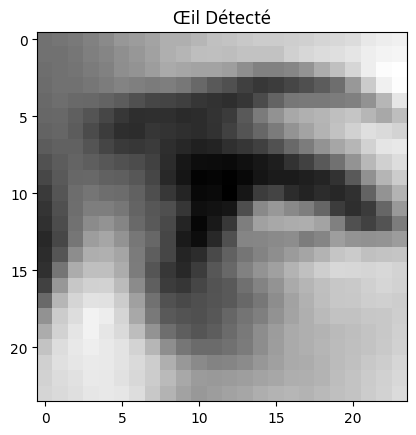

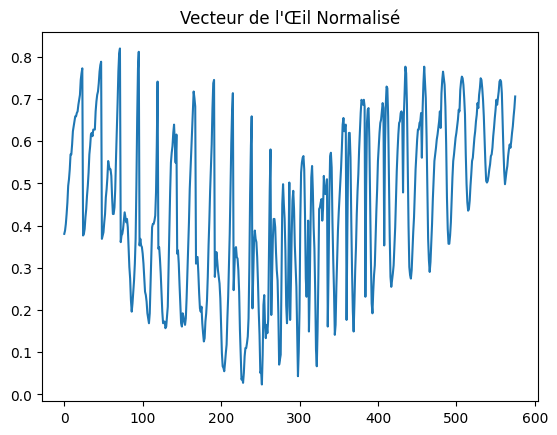

La classe prédite pour la nouvelle image est : 2
On charge l'image 086524.jpg


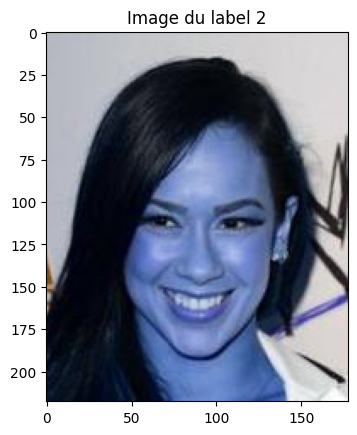

In [10]:
import json

# Supposons que 'nouveau_vecteur' est le vecteur de la nouvelle image
# et que 'vecteurs_moyens' est le dictionnaire de vos vecteurs moyens

# Chemin vers votre fichier JSON
fichier_json = '../Data/mean_vectors_2_labels.json'

# Charger les vecteurs moyens à partir du fichier JSON
with open(fichier_json, 'r') as file:
    vecteurs_moyens = json.load(file)
    
nouveau_vecteur = vectoriser_oeil(img, show_results=True, scale_factor=1.2)

if nouveau_vecteur is None or len(nouveau_vecteur) == 0:
    print("Aucun œil détecté ou erreur dans la vectorisation de l'image. Len = ", len(nouveau_vecteur))
else:
    classe_predite = classifier(nouveau_vecteur, vecteurs_moyens)
    print(f"La classe prédite pour la nouvelle image est : {classe_predite}")
    pick_random_img_in_label(classe_predite)